In [1]:
import pandas as pd
import os
import glob
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
file_directory = 'datasets/moex'
file_paths = glob.glob(os.path.join(file_directory, '*_moex_10m_data.csv'))

In [3]:
def preprocess_data(file_path, window=5):
    data = pd.read_csv(file_path)
    data['Datetime'] = pd.to_datetime(data['Datetime'])
    data = data.sort_values(by='Datetime')

    # Удаление выбросов
    Q1 = data['Close'].quantile(0.25)
    Q3 = data['Close'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    data = data[(data['Close'] >= lower_bound) & (data['Close'] <= upper_bound)]
    # Очистка от пустых
    data = data.dropna(subset=['Close'])
    # Сглаживание
    data['Close_Smoothed'] = data['Close'].ewm(span=window).mean()

    return data

In [4]:
def process_ticker(file_path, seasonal_period=24):
    data = preprocess_data(file_path)

    # Сезонное наивное
    data['Seasonal_Naive_Forecast'] = data['Close_Smoothed'].shift(seasonal_period)
    data.dropna(subset=['Seasonal_Naive_Forecast'], inplace=True)

    seasonal_mae = mean_absolute_error(data['Close'], data['Seasonal_Naive_Forecast'])
    seasonal_mape = (abs((data['Close'] - data['Seasonal_Naive_Forecast']) / data['Close'])).mean() * 100

    # Линейная регрессия
    data['Time_Index'] = range(len(data))
    X = data[['Time_Index']]
    y = data['Close']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)
    model = LinearRegression()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    linear_mae = mean_absolute_error(y_test, y_pred)
    linear_mape = (abs((y_test - y_pred) / y_test)).mean() * 100
    linear_r2 = r2_score(y_test, y_pred)

    ticker_name = os.path.basename(file_path).split('_')[0]
    return {
        'Ticker': ticker_name,
        'Seasonal_MAE': seasonal_mae,
        'Seasonal_MAPE': seasonal_mape,
        'Linear_MAE': linear_mae,
        'Linear_MAPE': linear_mape,
        'Linear_R2': linear_r2
    }

results = []
for file_path in file_paths:
    try:
        results.append(process_ticker(file_path))
    except Exception as e:
        print(f"не обработалось {file_path}: {e}")

results_df = pd.DataFrame(results)

results_df.to_csv('ticker_analysis_results.csv', index=False)

## Методы прогнозирования

- **Seasonal_MAE**: Средняя абсолютная ошибка для сезонного наивного прогноза.
- **Seasonal_MAPE**: Средняя абсолютная процентная ошибка для сезонного наивного прогноза.
- **Linear_MAE**: Средняя абсолютная ошибка для линейной регрессии.
- **Linear_MAPE**: Средняя абсолютная процентная ошибка для линейной регрессии.
- **Linear_R²**: Доля объяснённой вариации данных в линейной регрессии.

## Метрики качества
| **Метрика**        | **Хорошее значение** | **Среднее значение** | **Плохое значение** |
|---------------------|----------------------|-----------------------|----------------------|
| **Seasonal_MAE**    | ≤ 5                 | 5–20                 | > 20                |
| **Seasonal_MAPE**   | ≤ 5%                | 5–15%                | > 15%               |
| **Linear_MAE**      | ≤ 10                | 10–50                | > 50                |
| **Linear_MAPE**     | ≤ 10%               | 10–20%               | > 20%               |
| **Linear_R²**       | ≥ 0.8               | 0.5–0.8              | < 0.5               |


In [5]:
print("Results DataFrame:")
print(results_df.head())

Results DataFrame:
  Ticker  Seasonal_MAE  Seasonal_MAPE  Linear_MAE  Linear_MAPE  Linear_R2
0  TATNP      1.373419       0.287840   67.025842    10.574173  -0.980810
1   FEES      0.000401       0.372399    0.015381    16.975550  -0.415064
2   FIVE      6.925141       0.414468  658.675675    27.111508  -6.423366
3   RTKM      0.217335       0.293715   12.539598    13.934965  -1.016075
4   POSI      6.586024       0.382501  319.644899    11.977419  -2.258895


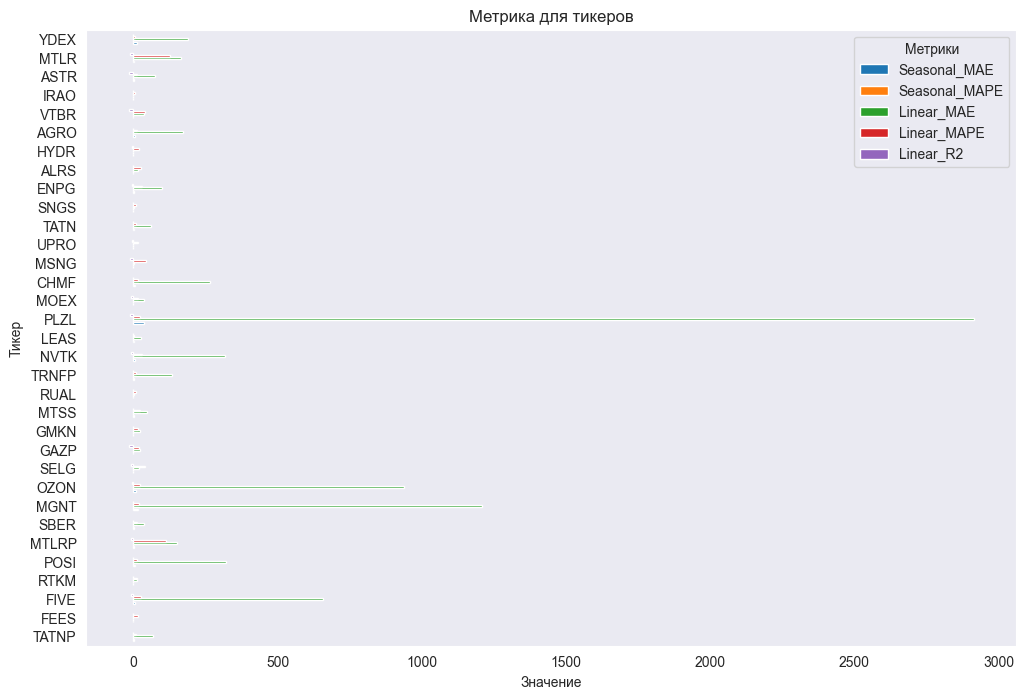

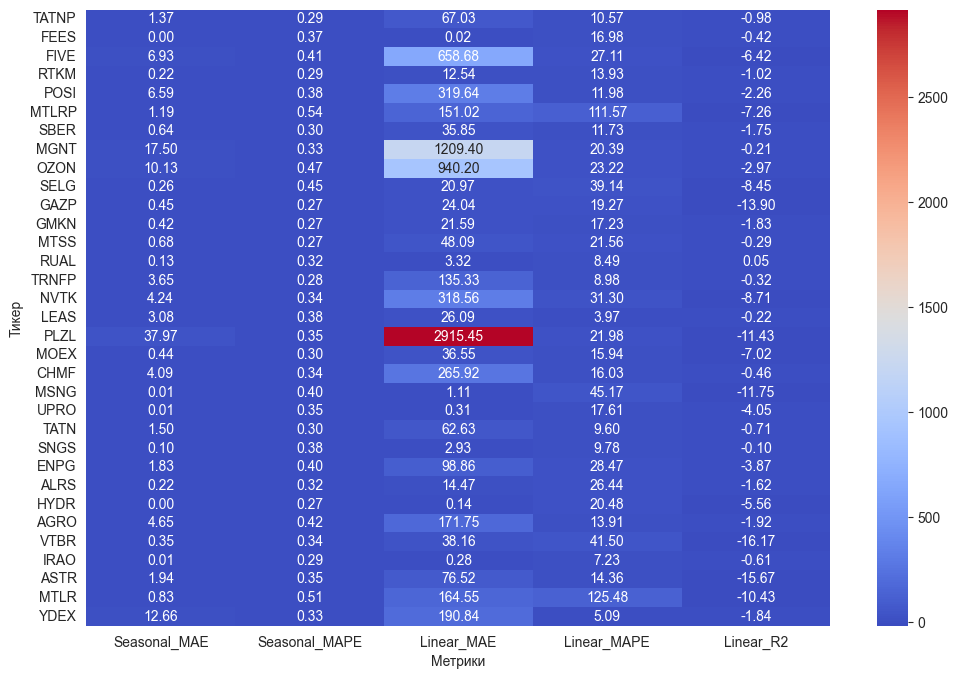

In [6]:
if not results_df.empty:
    results_df.set_index('Ticker', inplace=True)
    metrics = ['Seasonal_MAE', 'Seasonal_MAPE', 'Linear_MAE', 'Linear_MAPE', 'Linear_R2']

    results_df[metrics].plot(kind='barh', figsize=(12, 8))
    plt.title('Метрика для тикеров')
    plt.xlabel('Значение')
    plt.ylabel('Тикер')
    plt.legend(title='Метрики')
    plt.grid()
    plt.show()

    plt.figure(figsize=(12, 8))
    sns.heatmap(results_df[metrics], annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
    plt.xlabel('Метрики')
    plt.ylabel('Тикер')
    plt.show()
else:
    print("Нет данных.")